# Pre procesamiento y organizacion 

## Ver imagenes

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Directorios de imágenes y etiquetas
images_path = 'datasetssetssets/cropped_images'
labels_path = 'datasets/cropped_labels'

# Dimensiones objetivo (ejemplo 416x416 para YOLO)
img_size = (416, 416)

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(img_name):
    img_path = os.path.join(images_path, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"No se encontró la imagen: {img_name}")
        return None
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalización a rango [0, 1]
    return img

# Función para cargar las etiquetas correspondientes
def load_labels(label_name):
    label_path = os.path.join(labels_path, label_name)
    if not os.path.exists(label_path):
        print(f"No se encontró el archivo de etiquetas: {label_name}")
        return []
    with open(label_path, 'r') as f:
        labels = [list(map(float, line.strip().split())) for line in f]
    return labels

# Función para visualizar la imagen con las etiquetas
def visualize_image_with_labels(img_name):
    # Cargar imagen y etiquetas
    img = load_and_preprocess_image(img_name)
    label_name = img_name.replace('.jpg', '.txt')
    labels = load_labels(label_name)
    
    if img is None:
        return
    
    # Convertir imagen al formato RGB para visualizar con Matplotlib
    img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    for label in labels:
        class_id, x_center, y_center, width, height = label
        x_center, y_center, width, height = (
            x_center * img_size[0], y_center * img_size[1],
            width * img_size[0], height * img_size[1]
        )
        top_left = (int(x_center - width / 2), int(y_center - height / 2))
        bottom_right = (int(x_center + width / 2), int(y_center + height / 2))
        plt.gca().add_patch(plt.Rectangle(top_left, width, height, linewidth=2, edgecolor='green', facecolor='none'))
        plt.text(top_left[0], top_left[1] - 5, f"Clase {int(class_id)}", color='green', fontsize=10)
    
    plt.axis('off')
    plt.show()


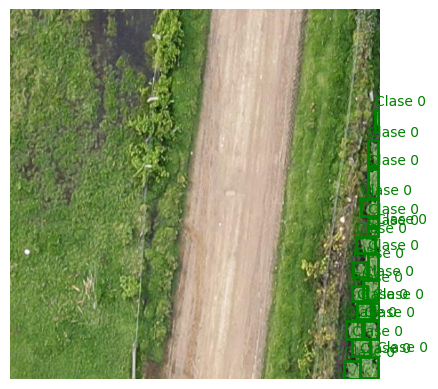

In [10]:
# Ejemplo de uso: pasa el nombre de la imagen (e.g., "imagen1.jpg")
visualize_image_with_labels("18_crop_10.jpg")

## Mover imagenes a posicion adecuada

In [4]:
import os
import shutil
import random
from PIL import Image
import numpy as np

# Directorios originales y destino
images_path = 'datasets/cropped_images'
labels_path = 'datasets/cropped_labels'

train_images_path = 'datasets/images/train'
val_images_path = 'datasets/images/val'
test_images_path = 'datasets/images/test'
train_labels_path = 'datasets/labels/train'
val_labels_path = 'datasets/labels/val'
test_labels_path = 'datasets/labels/test'

# Crear carpetas
for path in [train_images_path, val_images_path, test_images_path,
             train_labels_path, val_labels_path, test_labels_path]:
    os.makedirs(path, exist_ok=True)

# Splits
train_split, val_split, test_split = 0.7, 0.15, 0.15

def normalize_label(label_path, img_width, img_height):
    """Normaliza las etiquetas y corrige valores negativos"""
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        normalized_lines = []
        for line in lines:
            values = [float(x) for x in line.strip().split()]
            if len(values) != 5:
                continue
                
            # Corregir valores negativos y normalizar
            class_id = 0
            x_center = abs(values[1])  # Usar valor absoluto para coordenadas
            y_center = abs(values[2])
            width = abs(values[3])     # Usar valor absoluto para dimensiones
            height = abs(values[4])
            
            # Asegurar que están en rango 0-1
            x_center = min(max(x_center, 0), 1)
            y_center = min(max(y_center, 0), 1)
            width = min(max(width, 0.01), 1)    # Mínimo 1% del ancho
            height = min(max(height, 0.01), 1)   # Mínimo 1% del alto
            
            normalized_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            normalized_lines.append(normalized_line)
        
        return normalized_lines
    except Exception as e:
        print(f"Error procesando {label_path}: {str(e)}")
        return None

def move_and_normalize_files(file_list, src_img_dir, src_lbl_dir, dest_img_dir, dest_lbl_dir):
    valid_files = 0
    for file_name in file_list:
        img_src = os.path.join(src_img_dir, file_name)
        lbl_src = os.path.join(src_lbl_dir, file_name.replace('.jpg', '.txt'))
        
        # Verificar si existen tanto la imagen como la etiqueta
        if not (os.path.exists(img_src) and os.path.exists(lbl_src)):
            print(f"Saltando {file_name}: Falta imagen o etiqueta")
            continue
        
        try:
            # Leer dimensiones de la imagen
            with Image.open(img_src) as img:
                img_width, img_height = img.size
            
            # Normalizar etiquetas
            normalized_lines = normalize_label(lbl_src, img_width, img_height)
            if not normalized_lines:
                print(f"Saltando {file_name}: Error en etiquetas")
                continue
            
            # Si hay etiquetas válidas, copiar imagen y guardar etiquetas normalizadas
            if normalized_lines:
                img_dest = os.path.join(dest_img_dir, file_name)
                lbl_dest = os.path.join(dest_lbl_dir, file_name.replace('.jpg', '.txt'))
                
                # Copiar imagen
                shutil.copy(img_src, img_dest)
                
                # Guardar etiquetas normalizadas
                with open(lbl_dest, 'w') as f:
                    f.writelines(normalized_lines)
                
                valid_files += 1
                
        except Exception as e:
            print(f"Error procesando {file_name}: {str(e)}")
            continue
    
    return valid_files

# Filtrar solo archivos de imagen válidos que tienen etiquetas
image_files = []
for img_file in os.listdir(images_path):
    if img_file.endswith('.jpg'):
        lbl_file = os.path.join(labels_path, img_file.replace('.jpg', '.txt'))
        if os.path.exists(lbl_file):
            image_files.append(img_file)

# Mezclar y dividir
random.shuffle(image_files)
num_train = int(len(image_files) * train_split)
num_val = int(len(image_files) * val_split)

train_files = image_files[:num_train]
val_files = image_files[num_train:num_train + num_val]
test_files = image_files[num_train + num_val:]

# Procesar cada conjunto
print("\nProcesando conjunto de entrenamiento:")
train_count = move_and_normalize_files(train_files, images_path, labels_path, train_images_path, train_labels_path)

print("\nProcesando conjunto de validación:")
val_count = move_and_normalize_files(val_files, images_path, labels_path, val_images_path, val_labels_path)

print("\nProcesando conjunto de prueba:")
test_count = move_and_normalize_files(test_files, images_path, labels_path, test_images_path, test_labels_path)

print(f"\nResumen:")
print(f"Imágenes de entrenamiento procesadas: {train_count}")
print(f"Imágenes de validación procesadas: {val_count}")
print(f"Imágenes de prueba procesadas: {test_count}")


Procesando conjunto de entrenamiento:
Saltando 68_crop_20.jpg: Error en etiquetas
Saltando 68_crop_10.jpg: Error en etiquetas
Saltando 69_crop_22.jpg: Error en etiquetas
Saltando 22_crop_1.jpg: Error en etiquetas
Saltando 53_crop_3.jpg: Error en etiquetas
Saltando 46_crop_12.jpg: Error en etiquetas
Saltando 53_crop_16.jpg: Error en etiquetas
Saltando 53_crop_24.jpg: Error en etiquetas
Saltando 46_crop_21.jpg: Error en etiquetas
Saltando 53_crop_14.jpg: Error en etiquetas
Saltando 22_crop_8.jpg: Error en etiquetas
Saltando 69_crop_23.jpg: Error en etiquetas
Saltando 17_crop_20.jpg: Error en etiquetas
Saltando 23_crop_13.jpg: Error en etiquetas
Saltando 47_crop_18.jpg: Error en etiquetas
Saltando 48_crop_6.jpg: Error en etiquetas
Saltando 70_crop_21.jpg: Error en etiquetas
Saltando 70_crop_22.jpg: Error en etiquetas
Saltando 24_crop_19.jpg: Error en etiquetas
Saltando 23_crop_19.jpg: Error en etiquetas
Saltando 54_crop_11.jpg: Error en etiquetas
Saltando 24_crop_7.jpg: Error en etiqueta

## Revisar tamaño de imagenes

In [ ]:
import os
import os.path as osp
from PIL import Image
import pandas as pd

# Definir extensiones de imagen permitidas
IMG_EXT = {'.jpg', '.jpeg', '.png'}

# Listas para almacenar información de las imágenes
img_name_list = []
img_width_list = []
img_height_list = []
img_folder_list = []
img_format_list = []

# Lista de carpetas de imágenes
images_folder_list = ['datasets/images/train', 'datasets/images/val', 'datasets/images/test']

# Recorrer las carpetas de imágenes
for folder in images_folder_list:
    for fname in os.listdir(folder):
        img_folder_list.append(folder)
        img_name_list.append(fname)
        img_path = osp.join(folder, fname)
        
        # Verificar si el formato de la imagen es correcto
        img_format = "ok" if osp.splitext(fname)[-1].lower() in IMG_EXT else "not ok"
        img_format_list.append(img_format)
        
        # Obtener dimensiones de la imagen
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                img_width_list.append(width)
                img_height_list.append(height)
        except Exception as e:
            print(f"Error al abrir {fname} en {folder}: {e}")
            img_width_list.append(None)
            img_height_list.append(None)

# Crear DataFrame con la información de las imágenes
data_model = {
    "folder": img_folder_list,
    "image_name": img_name_list,
    "width": img_width_list,
    "height": img_height_list,
    "format": img_format_list
}
report_df = pd.DataFrame(data=data_model)

# Mostrar el DataFrame
print(report_df)


                folder      image_name  width  height format
0    data/images/train  16_crop_24.jpg    640     640     ok
1    data/images/train  17_crop_11.jpg    640     640     ok
2    data/images/train  17_crop_12.jpg    640     640     ok
3    data/images/train  17_crop_16.jpg    640     640     ok
4    data/images/train  17_crop_17.jpg    640     640     ok
..                 ...             ...    ...     ...    ...
217   data/images/test  70_crop_15.jpg    640     640     ok
218   data/images/test   70_crop_7.jpg    640     640     ok
219   data/images/test  72_crop_18.jpg    640     640     ok
220   data/images/test   72_crop_4.jpg    640     640     ok
221   data/images/test   72_crop_6.jpg    640     640     ok

[222 rows x 5 columns]


In [2]:
import os
import numpy as np

def verify_dataset(images_dir, labels_dir):
    print(f"Verificando directorio: {images_dir}")
    
    # Contar archivos
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    
    print(f"Número de imágenes: {len(image_files)}")
    print(f"Número de etiquetas: {len(label_files)}")
    
    # Verificar contenido de etiquetas
    invalid_labels = []
    empty_labels = []
    
    for label_file in label_files:
        img_file = label_file.replace('.txt', '.jpg')
        if img_file not in image_files:
            print(f"Advertencia: Etiqueta sin imagen correspondiente: {label_file}")
            continue
            
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            content = f.readlines()
            
        if len(content) == 0:
            empty_labels.append(label_file)
            continue
            
        for line in content:
            try:
                values = [float(x) for x in line.strip().split()]
                if len(values) != 5:
                    invalid_labels.append(label_file)
                    break
                if values[0] != 0:  # class_id debe ser 0
                    invalid_labels.append(label_file)
                    break
                # Verificar que las coordenadas estén normalizadas
                if any(x < 0 or x > 1 for x in values[1:]):
                    invalid_labels.append(label_file)
                    break
            except:
                invalid_labels.append(label_file)
                break
    
    print(f"Etiquetas vacías: {len(empty_labels)}")
    print(f"Etiquetas inválidas: {len(invalid_labels)}")
    if invalid_labels:
        print("Primeras 5 etiquetas inválidas:", invalid_labels[:5])
    
    return len(empty_labels) == 0 and len(invalid_labels) == 0

# Verificar cada conjunto
for split in ['train', 'val', 'test']:
    images_path = f'datasets/images/{split}'
    labels_path = f'datasets/labels/{split}'
    print(f"\nVerificando conjunto {split}:")
    verify_dataset(images_path, labels_path)


Verificando conjunto train:
Verificando directorio: datasets/images/train
Número de imágenes: 155
Número de etiquetas: 155
Etiquetas vacías: 82
Etiquetas inválidas: 70
Primeras 5 etiquetas inválidas: ['17_crop_11.txt', '17_crop_12.txt', '17_crop_16.txt', '17_crop_17.txt', '17_crop_5.txt']

Verificando conjunto val:
Verificando directorio: datasets/images/val
Número de imágenes: 33
Número de etiquetas: 33
Etiquetas vacías: 23
Etiquetas inválidas: 10
Primeras 5 etiquetas inválidas: ['21_crop_24.txt', '48_crop_20.txt', '49_crop_22.txt', '49_crop_7.txt', '54_crop_23.txt']

Verificando conjunto test:
Verificando directorio: datasets/images/test
Número de imágenes: 34
Número de etiquetas: 34
Etiquetas vacías: 17
Etiquetas inválidas: 17
Primeras 5 etiquetas inválidas: ['16_crop_11.txt', '46_crop_9.txt', '47_crop_10.txt', '48_crop_16.txt', '48_crop_5.txt']


In [3]:
verify_dataset(images_dir= "./datasets/images", labels_dir="./datasets/labels")

Verificando directorio: ./datasets/images
Número de imágenes: 0
Número de etiquetas: 0
Etiquetas vacías: 0
Etiquetas inválidas: 0


True